In [1]:
# estimate the onset of coronavirus outbreak and peak number of confirmed cases

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.plotting.register_matplotlib_converters()

# confirmed cases are expected to be monotonically increasing, but they are not
data_source = "../data/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

source_df = pd.read_csv(data_source)


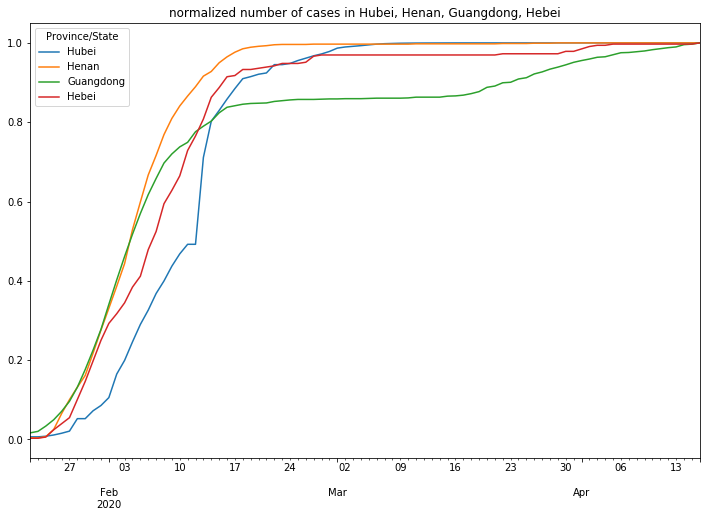

In [2]:
# plot provinces in china (normalized)

china_df = source_df[source_df["Country/Region"] == "China"]
china_df.set_index("Province/State", inplace=True)

timeseries_df = china_df.filter(regex='^[0-9/]+$', axis=1)
timeseries_df.columns = pd.to_datetime(timeseries_df.columns)

# normalize per-row by max
normalized_df = timeseries_df.apply(lambda x: x / x.max(), axis=1)
# normalized_df

provinces = ["Hubei", "Henan", "Guangdong", "Hebei"]
plot_df = normalized_df.loc[provinces].transpose()

plot_df.plot(figsize=(12, 8), legend=True, title="normalized number of cases in {}".format(", ".join(provinces)))

In [3]:
# squash countries and index with countries, produce normalized

country_df = source_df.groupby("Country/Region").sum()

country_df = country_df.filter(regex='^[0-9/]+$', axis=1)
country_df.columns = pd.to_datetime(timeseries_df.columns)

num_cases_cutoff = 100
country_df = country_df[country_df[country_df.columns[-1]] > num_cases_cutoff]

# normalize per-row by max
country_df_normalized = country_df.apply(lambda x: x / x.max(), axis=1)

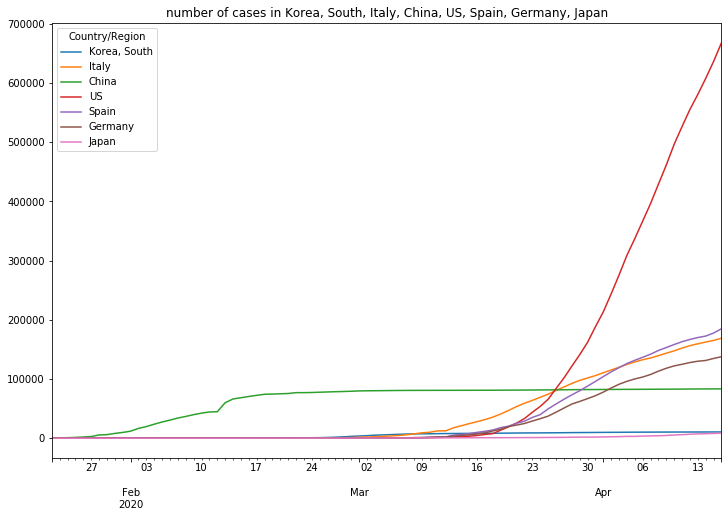

In [16]:
# plot countries (absolute)

countries = ["Korea, South", "Italy", "China", "US", "Spain", "Germany", "Japan"]
countries_df = country_df.loc[countries]

plot_df = countries_df.transpose()
plot_df.plot(figsize=(12, 8), legend=True, title="number of cases in {}".format(", ".join(countries)))


In [6]:
# parsing US daily number of tests (CDC)

us_daily_tests_raw = "../data/us_number_of_tests.raw"
us_daily_tests_csv = "../data/us_number_of_tests.csv"
cnt = -1

with open(us_daily_tests_raw, "r") as rfile, open(us_daily_tests_csv, "w") as wfile:
    # slow but whatever
    for line in rfile:
        cnt += 1
        if cnt == 0:
            wfile.write(line.strip().replace("\t", ",") + "\n")
        else:
            parts = line.strip().split("\t")
            # public health labs data being collected, then skip
            # cdc labs data being collected, ignore, as their numbers are low
            if not parts[2][-1].isdigit():
                continue
            else:
                wfile.write(parts[0] + "/20," + parts[1].replace("‡", "") + "," + parts[2] + "\n")
                
us_tests_df = pd.read_csv(us_daily_tests_csv)
us_tests_df['total_tests_daily'] = us_tests_df['CDC Labs'] + us_tests_df['US Public Health Labs']
us_tests_df['total_tests'] = us_tests_df['total_tests_daily'].cumsum()
us_tests_df['Date Collected'] = pd.to_datetime(us_tests_df['Date Collected'], format="%m/%d/%y")
us_tests_df = us_tests_df.set_index('Date Collected')


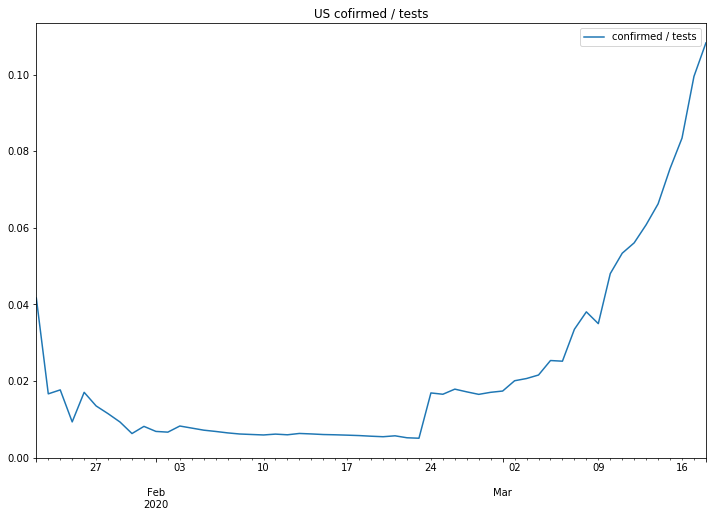

In [7]:
# plot us number of cases / number of tests
# assuming they don't retest confirmed cases, which must be very much untrue

us_cases_df = country_df.loc["US"]

us_joined_df = us_tests_df.merge(us_cases_df.rename("confirmed_cases"), left_index=True, right_index=True)

us_joined_df['confirmed / tests'] = us_joined_df['confirmed_cases'] / us_joined_df['total_tests']
us_joined_df['confirmed / tests'].transpose().plot(figsize=(12, 8), legend=True, title="US cofirmed / tests")

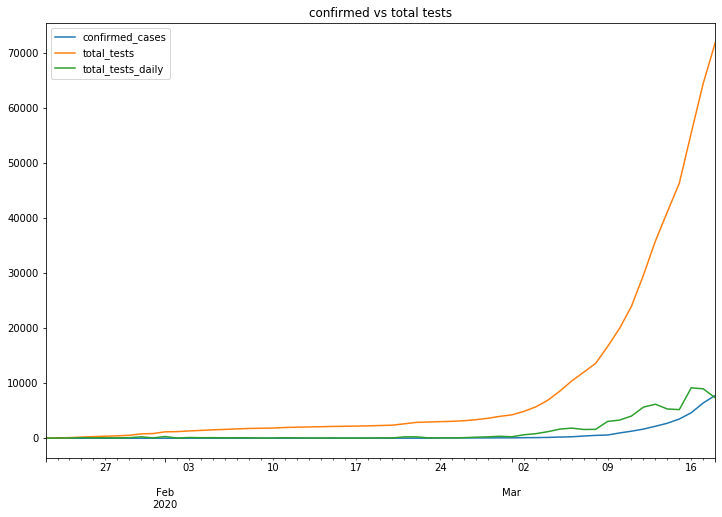

In [8]:
# plot the total number of cases and total number of tests
us_joined_df['confirmed_cases'].transpose().plot(figsize=(12, 8), legend=True, title="confirmed vs total tests")
us_joined_df['total_tests'].transpose().plot(figsize=(12, 8), legend=True, title="confirmed vs total tests")
us_joined_df['total_tests_daily'].transpose().plot(figsize=(12, 8), legend=True, title="confirmed vs total tests")

# depending on how many are retests on confirmed cases, the underlying graph could be very misleading in understanding
# how widespread the virus is.


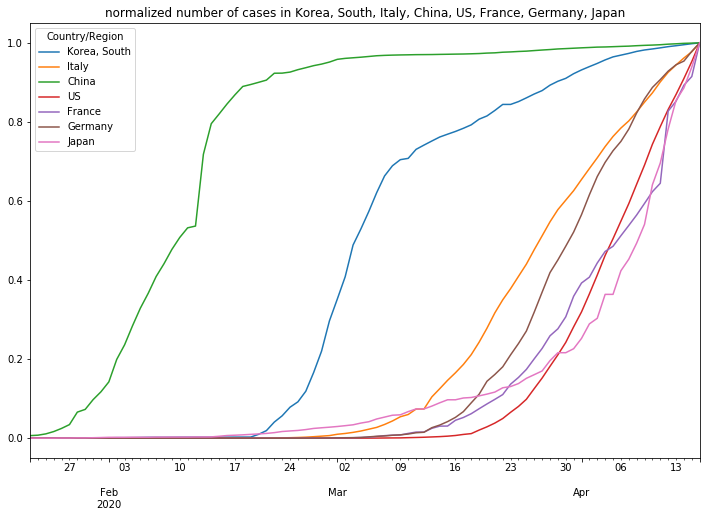

In [9]:
# plot countries (normalized)

# source_df["Country/Region"].unique()
# "Korea, South"
countries = ["Korea, South", "Italy", "China", "US", "France", "Germany", "Japan"]
countries_df = country_df_normalized.loc[countries]

plot_df = countries_df.transpose()
plot_df.plot(figsize=(12, 8), legend=True, title="normalized number of cases in {}".format(", ".join(countries)))

# Intuition:
# fit with the CDF of a Gaussian?
# Assumption is first derivative is Gaussian, each country has a lagged start.
# Fit the curve with "stabilized" countries and infer where the rest lies.


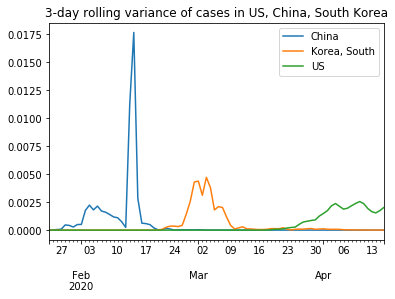

In [10]:
# investigate rolling variance as criteria for convergence

# expect the following two to be the same. Note the transpose
# print(country_df_normalized.transpose().rolling(3).var().dropna().transpose().loc["China"])
# print(country_df_normalized.loc["China"].rolling(3).var().dropna())

# rolling_var.loc["China"].plot()
# country_df_normalized["stabilized"] = rolling_var[-1]

country_df_normalized.loc["China"].rolling(3).var().dropna().plot(legend=True)
country_df_normalized.transpose().rolling(3).var().dropna().iloc[-1].transpose().head()

country_df_normalized.loc["Korea, South"].rolling(3).var().dropna().plot(legend=True)
country_df_normalized.loc["US"].rolling(3).var().dropna().plot(legend=True, title="3-day rolling variance of cases in US, China, South Korea")


In [11]:
# find converged countries
country_df_with_convergence = country_df_normalized.copy()
convergence_cutoff = 0.001

country_df_with_convergence["rolling_var"] = country_df_normalized.transpose().rolling(3).var().dropna().iloc[-1].transpose()
country_df_with_convergence["converged"] = country_df_with_convergence["rolling_var"] < convergence_cutoff

# converged countries
print("converged")
print(country_df_with_convergence.loc[country_df_with_convergence["converged"] == 1].index)

# growing countries
print("growing")
print(country_df_with_convergence.loc[country_df_with_convergence["converged"] == 0].index)


converged
Index(['Andorra', 'Australia', 'Austria', 'Brunei', 'Burkina Faso', 'Cambodia',
       'China', 'Costa Rica', 'Cote d'Ivoire', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Diamond Princess', 'Estonia', 'Finland', 'Germany', 'Ghana',
       'Greece', 'Honduras', 'Iceland', 'Iran', 'Iraq', 'Israel', 'Italy',
       'Jordan', 'Korea, South', 'Latvia', 'Lebanon', 'Lithuania',
       'Luxembourg', 'Madagascar', 'Malaysia', 'Malta', 'Mauritius',
       'Netherlands', 'New Zealand', 'Niger', 'Norway', 'Rwanda', 'Slovenia',
       'Sri Lanka', 'Switzerland', 'Taiwan*', 'Thailand',
       'Trinidad and Tobago', 'Uruguay', 'Vietnam'],
      dtype='object', name='Country/Region')
growing
Index(['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia',
       'Azerbaijan', 'Bahrain', 'Bangladesh', 'Belarus', 'Belgium', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Cameroon', 'Canada',
       'Chile', 'Colombia', 'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Cu

In [12]:
# time lag between two converged countries: time difference between peak of rolling variance

country_df_with_convergence["onset"] = country_df_normalized.transpose().rolling(3).var().dropna().idxmax()

country_onset = country_df_with_convergence.loc[country_df_with_convergence["converged"] == 1]["onset"]
lag_korea_china = country_onset['Korea, South'] - country_onset['China']

print("onset lag between Korea and China: {}".format(lag_korea_china))

onset lag between Korea and China: 18 days 00:00:00


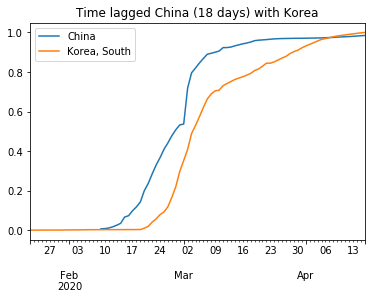

In [13]:
# time offset lagged Korea with China

countries = ["Korea, South", "China"]
countries_df = country_df_normalized.loc[countries]

shifted_df = country_df_normalized.loc["China"].shift(periods=lag_korea_china.days)

shifted_df.plot(legend=True)
country_df_normalized.loc["Korea, South"].plot(title="Time lagged China ({} days) with Korea".format(lag_korea_china.days), legend=True)


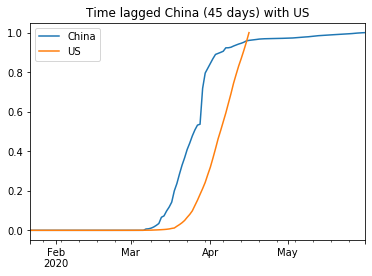

In [14]:
# attempt to time lag China to US

# arbitrary :(
shift_china_us = 45

later_df = pd.DataFrame(columns=pd.date_range(start=country_df_normalized.columns[-1], periods=shift_china_us + 1)[1:])

expanded_df = pd.concat([country_df_normalized, later_df])

expanded_df = expanded_df.loc["China"].shift(periods=shift_china_us, fill_value=0.0)
expanded_df.plot(legend=True)
country_df_normalized.loc["US"].plot(title="Time lagged China ({} days) with US".format(shift_china_us), legend=True)


Text(0.5, 1.0, 'Fit results: mu = 124.85,  std = 184.86')

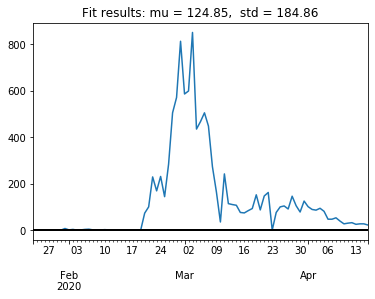

In [15]:
from scipy.stats import norm

country = "Korea, South"

gradient_df = country_df.diff(axis=1).iloc[:, 1:]
mu, std = norm.fit(gradient_df.loc[country].replace([np.inf, -np.inf], np.nan).dropna())

gradient_df.loc[country].plot()

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

# what's a good way to tell where in the slope we are at?
# normalize by the number of tests conducted?
